This file is to train a MLP to approximate MLP

In [6]:
run_python_script = False

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

if not run_python_script:
    plt.style.use(FIG_ROOT/"base.mplstyle")
    %matplotlib inline

In [8]:

import importlib
import models.mlp
importlib.reload(models.mlp)

<module 'models.mlp' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/mlp.py'>

In [9]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.mlp import SGMnet


In [10]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)


## Data, fn and paras

In [11]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [12]:
# load the dataset to get the freqs in real data (Apr 2, 2023)
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [13]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [14]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
paras_run.k = 0.15 # the parameter for reparameterization in logistic
paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

## Generate simulated data

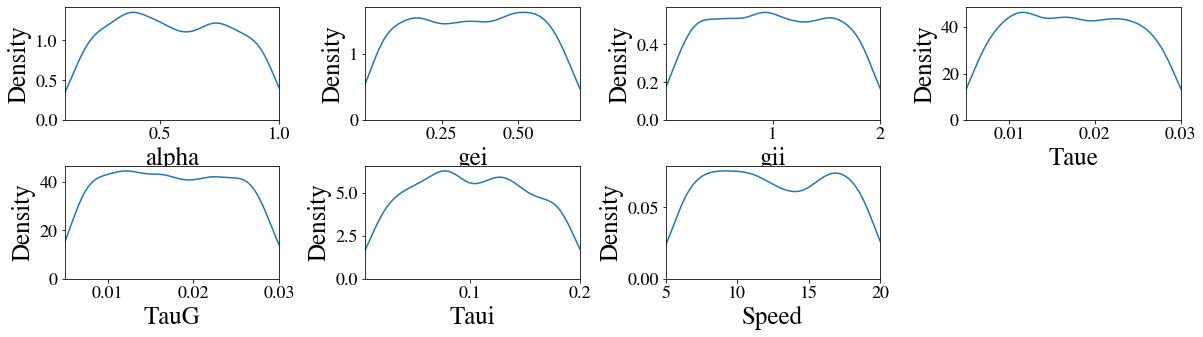

In [15]:
if not run_python_script:
    # show demo of generatingt simulation data (Speed is not a constant)
    #check the reparameterization
    sgm_params_raw = np.random.randn(1000, 7)*paras_run.sd
    sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
    
    plt.figure(figsize=[20, 5])
    for ix in range(7):
        plt.subplot(2, 4, ix+1)
        sns.kdeplot(sgm_paramss[:, ix])
        plt.xlim(paras.prior_bds[ix, :])
        plt.xlabel(paras.names[ix])

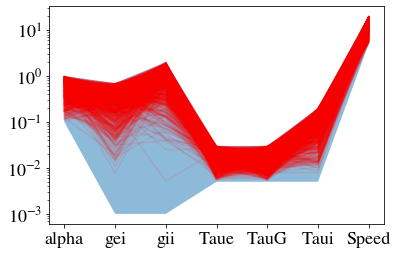

In [16]:
if not run_python_script:
    #check the reparameterization
    plt.fill_between(np.arange(7), paras.par_low, paras.par_high, alpha=0.5)
    plt.yscale("log")
    for cur_ts_sgm in sgm_paramss:
        plt.plot(np.arange(7), cur_ts_sgm, color="red", alpha=0.1)
    plt.xticks(np.arange(7), paras.names);
    plt.show()
    plt.close()

In [ ]:
if not run_python_script:
    sgm_params_raw = np.random.randn(10000, 7)*paras_run.sd
    sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
    
    sgmmodel = SGM(paras.C, paras.D, paras.freqs)
    PSDs = []
    for cur_sgm in tqdm(sgm_paramss):
        cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)[0]
        cur_PSD = cur_PSD[:68, :]
        PSDs.append(cur_PSD)
        
    simu_sgm_data = edict()
    simu_sgm_data.PSDs = np.array(PSDs)
    simu_sgm_data.sgm_paramss =  sgm_paramss
    simu_sgm_data.freqs = paras.freqs
    save_pkl_dict2folder(RES_ROOT/"simu_sgm_data_ind", simu_sgm_data, is_force=True)

  4%|████▋                                                                                                                               | 353/10000 [02:26<1:04:46,  2.48it/s]

In [ ]:
if not run_python_script:
    sgm_params_raw = np.random.randn(1000, 7)*paras_run.sd
    sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
    
    sgmmodel = SGM(paras.C, paras.D, paras.freqs)
    PSDs = []
    for cur_sgm in tqdm(sgm_paramss):
        cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)[0]
        cur_PSD = cur_PSD[:68, :]
        PSDs.append(cur_PSD)
        
    simu_sgm_data = edict()
    simu_sgm_data.PSDs_test = np.array(PSDs)
    simu_sgm_data.sgm_paramss_test =  sgm_paramss
    save_pkl_dict2folder(RES_ROOT/"simu_sgm_data_ind", simu_sgm_data, is_force=True)

## Train the model

In [11]:
from torch.utils.data import DataLoader, Dataset
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_sgm_data_ind")

In [18]:
class MyDataset(Dataset):
    def __init__(self, X, Y, is_std=True):
        """
        Initializes a new instance of the MyDataset class.

        Args:
            X (torch.Tensor or array-like): The input data.
            Y (torch.Tensor or array-like): The target data.
            is_std (bool, optional): Whether to standardize the target data. Defaults to True.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X)
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y)
        if is_std:
            # here I only divide by std of Y to keep the spatial features
            # In fact, it did not work for SGM to real MEG, so let me 
            # still std via the mean and std for each ROI and each data (Apr 3, 2023)
            Y = (Y-Y.mean(axis=2, keepdims=True))/Y.std(axis=2, keepdims=True)
        self.X = X
        self.Y = Y

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Gets the item at the specified index.

        Args:
            idx (int or str): The index of the item to get.

        Returns:
            tuple: A tuple containing the input data and target data.
        """
        if isinstance(idx, int):
            return self.X[idx], self.Y[idx]
        elif isinstance(idx, str) and idx.lower().startswith("all"):
            return self.X, self.Y


In [19]:
def evaluate(data, net, loss_fn=None):
    X_test, Y_test = data
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    net.eval()
    with torch.no_grad():
        Y_test_pred = net(X_test)
        loss = loss_fn(Y_test, Y_test_pred)

    net.train()
    return loss.item()

In [20]:
def weighted_mse_loss(pred, target, ws=None):
    """
    Calculates the weighted mean squared error loss between predicted and target values.

    Args:
        pred (torch.Tensor): predicted values
        target (torch.Tensor): target values
        ws (torch.Tensor, optional): weights for each value. Defaults to None.

    Returns:
        torch.Tensor: weighted mean squared error loss
    """
    if ws is None:
        ws = torch.ones_like(pred[0])
        ws[:, :20] = ws[:, :20]*10
    return torch.mean((pred-target)**2 * ws)

In [43]:
paras_sgm_net = edict()
paras_sgm_net.batchsize = 512
paras_sgm_net.nepoch = 6000
paras_sgm_net.loss_out = 100

In [44]:
# the data loader for training and testing
train_data = MyDataset(simu_sgm_data.sgm_paramss, simu_sgm_data.PSDs)
train_data_loader = DataLoader(train_data, batch_size=paras_sgm_net.batchsize, shuffle=True)

test_data = MyDataset(simu_sgm_data.sgm_paramss_test, simu_sgm_data.PSDs_test)

In [48]:
# the network
sgm_net = SGMnet(nroi=68, nfreq=len(paras.freqs))
loss_fn = nn.MSELoss()
loss_fn = weighted_mse_loss
optimizer = torch.optim.Adam(sgm_net.parameters(), lr=1e-3, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.50, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [49]:
# training
loss_cur = []
losses = []
losses_test = []

t0 = time.time()
for ie in range(paras_sgm_net.nepoch):
    for X_batch, Y_batch in train_data_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        Y_batch_est = sgm_net(X_batch)
        #print(Y_batch_est.sum(axis=(1, 2)))
        
        loss = loss_fn(Y_batch, Y_batch_est)
        #print(loss)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        loss_cur.append(loss.item())
        
    if ie % 100 == 99:
        scheduler.step()
    if ie % paras_sgm_net.loss_out == (paras_sgm_net.loss_out-1):
    
        losses.append(np.mean(loss_cur))
        losses_test.append(evaluate(test_data["all"], sgm_net))
        print(f"At epoch {ie+1}/{paras_sgm_net.nepoch},"
              f"the losses are {losses[-1]:.5f} (train)"
              f" and {losses_test[-1]:.5f} (test). "
              f"The time used is {delta_time(t0):.3f}s. "
              )
        loss_cur = []
        t0 = time.time()
    

Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 10/6000,the losses are 3.85760 (train) and 0.51029 (test). The time used is 12.098s. 
Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 20/6000,the losses are 3.72399 (train) and 0.49558 (test). The time used is 12.230s. 
Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 30/6000,the losses are 3.71188 (train) and 0.50914 (test). The time used is 12.640s. 
Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 40/6000,the losses are 3.66579 (train) and 0.49211 (test). The time used is 12.044s. 
Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 50/6000,the losses are 3.61326 (train) and 0.47072 (test). The time used is 12.907s. 
Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 60/6000,the losses are 3.54274 (train) and 0.46395 (test). The time used is 12.865s. 
Adjusting learning rate of group 0 to 1.0000e-03.
At epoch 70/6000,the losses are 3.50411 (train) and 0.44407 (test). The time use

KeyboardInterrupt: 

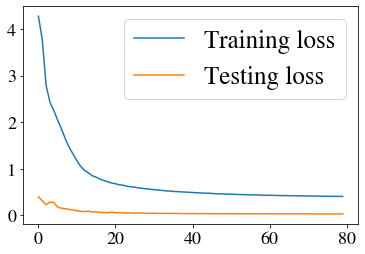

In [39]:
if not run_python_script:
    plt.plot(losses, label="Training loss")
    plt.plot(losses_test, label="Testing loss")
    plt.legend()

## Evaluate and save

In [34]:
X_test, Y_test = train_data["all"]
sgm_net.eval()
with torch.no_grad():
    Y_pred = sgm_net(X_test)

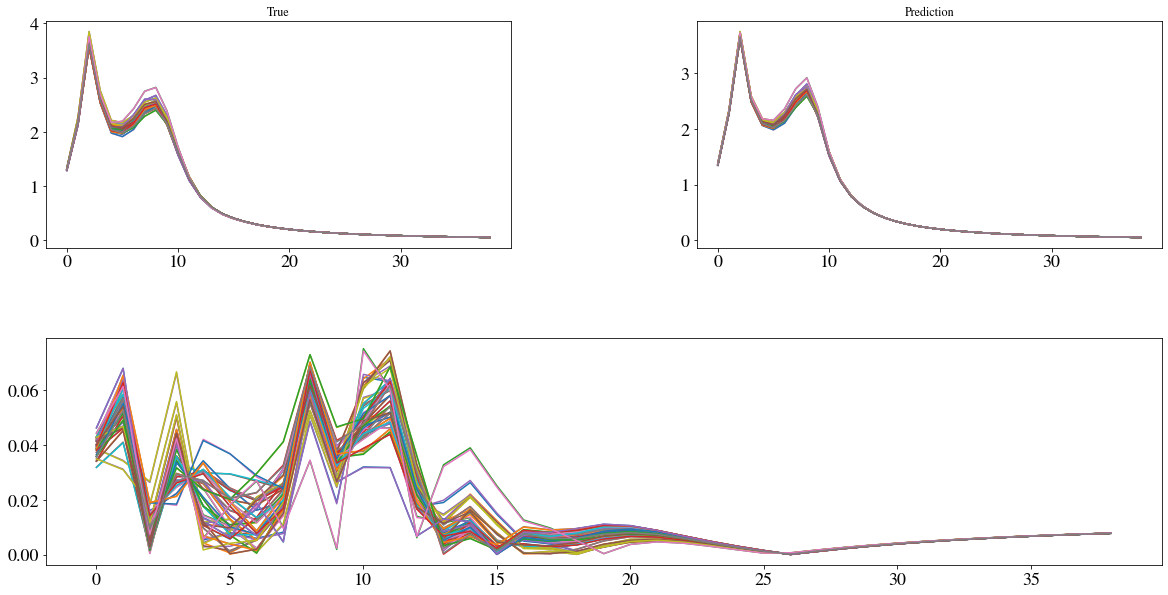

In [44]:
if not run_python_script:
    idx = 200
    curY_t = Y_test[idx]
    curY_p = Y_pred[idx]
    plt.figure(figsize=[20, 10])
    plt.subplot(221)
    plt.title("True")
    for iy in range(68):
        plt.plot(curY_p[iy, :])
    plt.subplot(222)
    plt.title("Prediction")
    for iy in range(68):
        plt.plot(curY_t[iy, :])
        #plt.plot(torch.abs(curY_p[iy, :]- curY_t[iy, :]))
    plt.subplot(212)
    for iy in range(68):
        plt.plot(torch.abs(curY_p[iy, :]- curY_t[iy, :])/curY_t[iy])

In [44]:
trained_model = edict()
trained_model.model = sgm_net.cpu()
trained_model.loss = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_sgm_net
trained_model.loss = losses
trained_model.loss_test = losses_test
trained_model.freqs = paras.freqs
save_pkl_dict2folder(RES_ROOT/"SGM_net", trained_model, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl


In [27]:
if not run_python_script:
    trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net1", excluding=["opt*"])

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net1/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net1/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net1/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net1/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net1/paras.pkl


In [38]:
if not run_python_script:
    X_test, Y_test = test_data["all"]
    trained_model.model.eval()
    with torch.no_grad():
        Y_pred = trained_model.model(X_test)
    loss_fn = nn.MSELoss()
    loss_fn(Y_test, Y_pred)

tensor(0.0321)